In [1]:
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas

print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/DAB/round_2/design
running on node: sofia


In 00_position_inputs, take the helix-binding hinge pdbs from starting_pdbs and make place two copies of the binding helix to buttress it. Set the chain order such that the binding helix is always on a terminus, either the N- or C-terminus depending on which curves more toward the hinge. Or if the helix is very straight, loop to the terminus which overhangs from the hinge less.

Looking at all the designs, overwhelmingly it was better to leave the C-terminus free. So I'll go ahead and decide that for this round, all DABs will have a C-terminal binding helix.

In [2]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "01_inpaint_structure"
design_list_file = "/home/broerman/crispy_shifty/projects/DAB/round_1/design/00_position_inputs/rough_ss_inputs.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/DAB/round_2/design", simulation_name)

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {
    "num_designs": 100,
    "rough_contigs": "1:0-0,2_4,1-3,3_4,1-3,4_0,0-0",
    "rough_tie_translate": "2,1.0:3,1.0",
    "contig_len_style": "input",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.inpainting.inpaint_structure",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="gpu",
    cores=2,
    memory="16G",
    gres="--gres=gpu:rtx2080:1",
    nstruct=5,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-180 /home/broerman/crispy_shifty/projects/DAB/round_2/design/01_inpaint_structure/run.sh


In [5]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "01_inpaint_structure"
design_list_file = "/home/broerman/crispy_shifty/projects/DAB/round_1/design/00_position_inputs/rough_ss_inputs.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/DAB/round_2/design", simulation_name)

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {
    "num_designs": 100,
    "rough_contigs": "1:0-0,2_8,1-3,3_8,1-3,4_0,0-0",
    "rough_tie_translate": "2,1.0:3,1.0",
    "contig_len_style": "input",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.inpainting.inpaint_structure",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="gpu",
    time="09:00:00",
    cores=2,
    memory="16G",
    gres="--gres=gpu:a4000:1",
    nstruct=5,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-90 /home/broerman/crispy_shifty/projects/DAB/round_2/design/01_inpaint_structure/run.sh


In [2]:
import os
import sys

sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = '01_inpaint_structure'
output_path = os.path.join("/home/broerman/crispy_shifty/projects/DAB/round_2/design", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [4]:
from crispy_shifty.utils.io import parse_scorefile_linear

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
# scores_df = scores_df.convert_dtypes()

  0%|          | 0/17927 [00:00<?, ?it/s]

In [7]:
import pyrosetta.distributed.cluster as cluster
from tqdm.auto import tqdm

for path, row in tqdm(scores_df.iterrows(), total=len(scores_df)):
    pdb_path = cluster.get_scores_dict(path)["instance"]["tasks"]["pdb_path"]
    scores_df.loc[path, "parent"] = pdb_path.split('/')[-1].split('.')[0]
    b_contig = row["contigs"].split(';')[1].split(',')[1][1:].split('-')
    scores_df.loc[path, "fragment_len"] = int(b_contig[1]) - int(b_contig[0]) + 1

  0%|          | 0/17927 [00:00<?, ?it/s]

In [8]:
scores_df.fragment_len.value_counts()

4.0    9000
8.0    8927
Name: fragment_len, dtype: int64

In [9]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

In [10]:
scores_df.columns

Index(['contigs', 'inpaint_length', 'inpaint_mean_lddt', 'inpaint_seq_resis',
       'inpaint_str_resis', 'sampled_mask', 'total_length', 'parent',
       'fragment_len'],
      dtype='object')

2it [00:00, 10.51it/s]


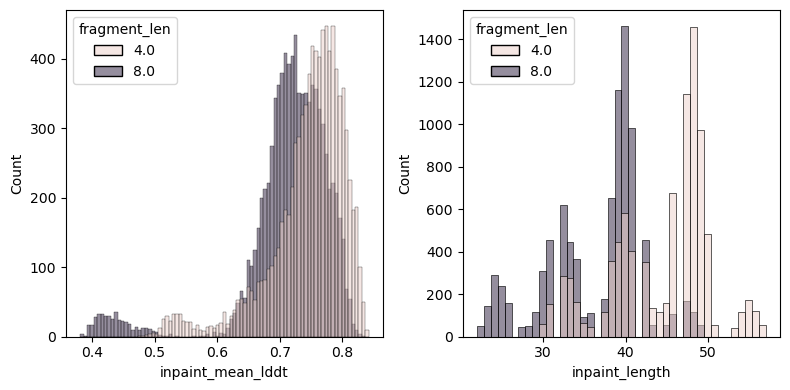

In [11]:
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df

cols = [
    "inpaint_mean_lddt",
    "inpaint_length",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    hue="fragment_len"
)
plt.savefig(os.path.join(output_path, "inpaint_scores.png"))

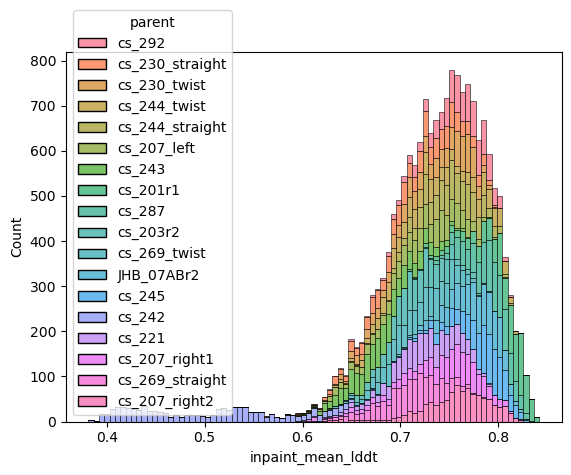

In [15]:
import seaborn as sns

sns.histplot(data=scores_df, x="inpaint_mean_lddt", hue="parent", multiple="stack")
plt.savefig(os.path.join(output_path, "inpaint_scores_byparent.png"))

<AxesSubplot:xlabel='inpaint_mean_lddt', ylabel='Count'>

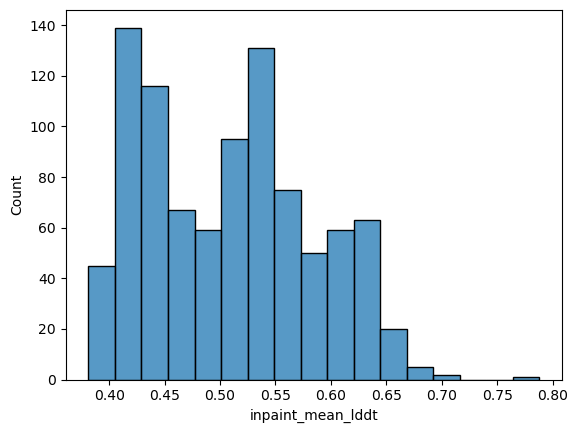

In [17]:
sns.histplot(data=scores_df.query("parent=='cs_242'"), x="inpaint_mean_lddt")

In [20]:
scores_df.inpaint_mean_lddt.mean()

0.7288427709861521

In [18]:
# get the best 10 designs per parent
target_representation = 100

scores_df.sort_values("inpaint_mean_lddt", ascending=False, inplace=True)
filtered_df = scores_df.groupby("parent", sort="False").head(target_representation)

In [19]:
filtered_df.inpaint_mean_lddt.mean()

0.7803409830729167

In [21]:
# Save a list of outputs

with open(os.path.join(output_path, "inpainted_structures.list"), "w") as f:
    for path in filtered_df.index:
        print(path, file=f)